# Compare surface DIC, Alk, & Ω

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import utils
import plot

import data_collections

import glodap 

xr.set_options(arithmetic_join='exact');

In [25]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.62:41770 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read the model data

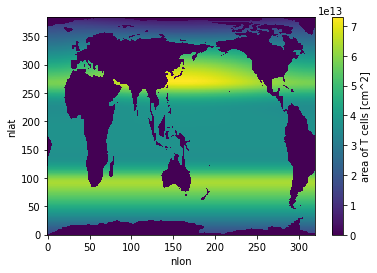

In [26]:
grid = pop_tools.get_grid('POP_gx1v7')
masked_area = grid.TAREA.where(grid.REGION_MASK > 0).fillna(0.)
masked_area.plot()

In [27]:
varlist = [
    'sDIC',
    'sALK',
    'Omega_arag',
]

obs_product = 'GLODAPv2.2016b_MappedClimatologies'

time_range = {
    'GLODAPv2.2016b_MappedClimatologies': ['2002-01-15', '2003-01-15'],
}

coll = data_collections.epoch_mean(
    query=dict(experiment='historical', stream='pop.h'),
    time_range=time_range[obs_product],
)
dsets = coll.to_dataset_dict(varlist, clobber=False)
_, ds = dsets.popitem()

with xr.set_options(keep_attrs=True):
    ds = ds.mean('member_id')

# mask out marginal seas    
ds = ds.where(masked_area)

# retain interesting variables
ds_full = ds[varlist]
ds = ds_full.isel(z_t=0)
ds

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320)
Coordinates:
    z_t         float32 500.0
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    sDIC        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    sALK        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Omega_arag  (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [28]:
client.close()
cluster.close()
del client
del cluster

## Read observational product

In [29]:
µmolkg_to_mmolm3 = 1026. * 1e-3 # µmol/kg --> mmol/m^3
Sbar = 35.

ds_obs_full = glodap.open_glodap_pop_grid(obs_product)
ds_obs_full = ds_obs_full.rename({'OmegaA': 'Omega_arag', 'OmegaC': 'Omega_calc'})

with xr.set_options(keep_attrs=True):
    # apply mask (omega data seems to have "0's" where it should have missing values
    for v in ['Omega_arag', 'Omega_calc']:
        ds_obs_full[v] = ds_obs_full[v].where(ds_obs_full.DIC)
        
    # convert units
    for v in ['DIC', 'ALK',]:
        if v in ds_obs_full:
            ds_obs_full[v] = ds_obs_full[v] * µmolkg_to_mmolm3
            ds_obs_full[v].attrs['units'] = 'mmol m$^{-3}$'            
        ds_obs_full[f's{v}'] = ds_obs_full[v] * Sbar / ds_obs_full.salinity

ds_obs = ds_obs_full[varlist].isel(z_t=0)
        
ds_obs

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv2.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320)
Coordinates:
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    z_t         float64 500.0
    dz          float64 10.0
    KMT         (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: nlat, nlon
Data variables:
    sDIC        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    sALK        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Omega_arag  (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins       (basins) <U14 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
Data variables:
    sDIC         (basins, z_t, lat_t) float64 ...
    sALK         (basins, z_t, lat_t) float64 ...
    sDIC_obs     (basins, z_t, lat_t) float64 ...
    sALK_obs     (basins, z_t, lat_t) float64 ...
    sDIC_bias    (basins, z_t, lat_t) float64 nan nan 87.12 ... nan nan nan
    sALK_bias    (basins, z_t, lat_t) float64 nan nan -40.73 ... nan nan nan

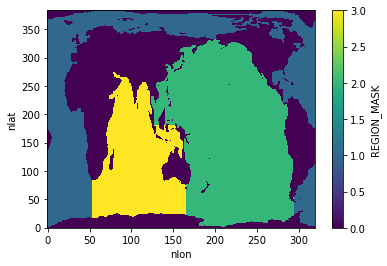

In [30]:
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask3d = utils.get_pop_region_mask_za(mask_type='3D')
basins = mask3d.region.rename({'region': 'basins'})
mask2d.plot()

ds_list_o = []
ds_list_m = []
for v in ['sDIC', 'sALK']:
    ds_list_o.append(
        utils.zonal_mean_via_fortran(
            ds_obs_full, var=v, 
            grid='POP_gx1v7', 
            region_mask=mask2d,
            replace_kmt=True,
        )
    )
    ds_list_m.append(
        utils.zonal_mean_via_fortran(
            ds_full, var=v, 
            grid='POP_gx1v7', 
            region_mask=mask2d,
        )
    )

ds_za = xr.merge(ds_list_o)
ds_za = ds_za.rename({k: f'{k}_obs' for k in ds_za.data_vars})
ds_za = ds_za.drop(['z_t'])
ds_za = xr.merge((xr.merge(ds_list_m), ds_za))
ds_za['basins'] = basins

for v in ['sDIC', 'sALK']:
    ds_za[f'{v}_bias'] = ds_za[v] - ds_za[f'{v}_obs']
                  
ds_za

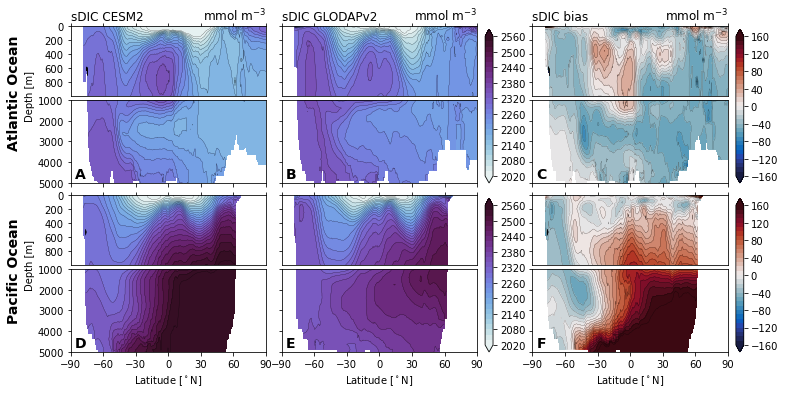

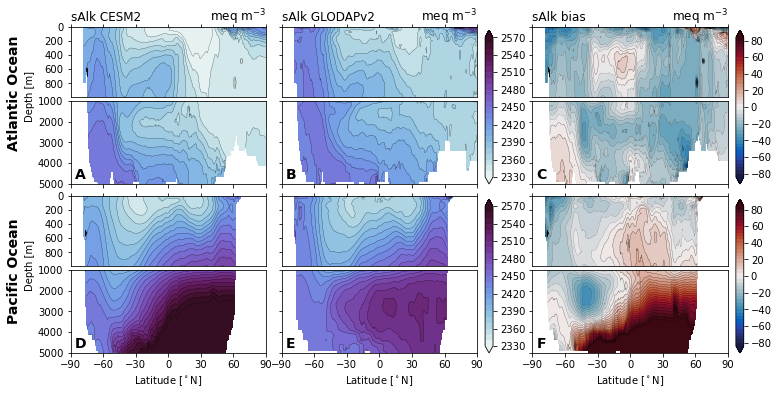

In [31]:
levels_za = dict()
levels_za_bias = dict()
for field in ['sDIC', 'sALK']:
    levels_za[field] = plot.nice_levels(ds_za[field], percentile=[2.5, 97.5])
    
    lev = list(plot.nice_levels(ds_za[f'{field}_bias'], percentile=[2.5, 97.5]))
    tmp = np.max(np.abs(lev))
    dc = np.diff(lev)[0]
    levels_za_bias[field] = list(np.arange(-1.0 * tmp, tmp + dc, dc))
    
    plot.za_obs_comparison(
        ds_za, 
        field=field, 
        levels=levels_za[field], 
        levels_bias=levels_za_bias[field],
        col_name=['CESM2', 'GLODAPv2', 'bias'],
    )
    utils.savefig(f'za-obs-comparison-{field}')

## Compute bias field

In [32]:
ds_bias = ds[['TLAT', 'TLONG']]
for v in varlist:
    ds_bias[v] = ds[v] - ds_obs[v]
ds_bias

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320)
Coordinates:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    z_t         float32 500.0
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    dz          float64 10.0
    KMT         (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: nlat, nlon
Data variables:
    sDIC        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    sALK        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Omega_arag  (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [33]:
ds_surf_plot = utils.pop_add_cyclic(ds)
ds_surf_obs_plot = utils.pop_add_cyclic(ds_obs)
ds_surf_bias_plot = utils.pop_add_cyclic(ds_bias)
ds_surf_plot

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 321)
Coordinates:
    z_t         float32 500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG       (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
    sDIC        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    sALK        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Omega_arag  (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan

## Make plots

In [34]:
levels = dict()
levels_bias = dict()
for v in varlist:
    # main plot
    levels[v] = plot.nice_levels(ds_obs[v], percentile=[2.5, 97.5])
    
    # bias plot
    lev = plot.nice_levels(ds_bias[v], percentile=[2.5, 97.5])
    tmp = np.max(np.abs(lev))
    dc = np.diff(lev)[0]
    levels_bias[v] = np.arange(-1.0 * tmp, tmp + dc, dc)

levels

{'sDIC': array([2000., 2020., 2040., 2060., 2080., 2100., 2120., 2140., 2160.,
        2180., 2200., 2220., 2240., 2260., 2280., 2300., 2320., 2340.,
        2360.]),
 'sALK': array([2340., 2350., 2360., 2370., 2380., 2390., 2400., 2410., 2420.,
        2430., 2440., 2450., 2460., 2470., 2480., 2490., 2500., 2510.]),
 'Omega_arag': array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
        2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
        4.1])}

In [35]:
cmap_field = cmocean.cm.dense
cmap_bias = cmocean.cm.balance
     
cmap_field.set_bad(color='white')
cmap_bias.set_bad(color='white')

contour_spec = {}
long_name = {}
for field in ['sDIC', 'sALK', 'Omega_arag']:
    contour_spec[field] = dict(
        levels=levels[field],
        extend='both',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),        
    )
    contour_spec[f'{field}_bias'] = dict(
        levels=levels_bias[field],
        extend='both',
        cmap=cmap_bias,
        norm=colors.BoundaryNorm(levels_bias[field], ncolors=cmap_field.N),        
    )
    long_name[field] = field if field != 'Omega_arag' else '$\Omega_{arag}$'

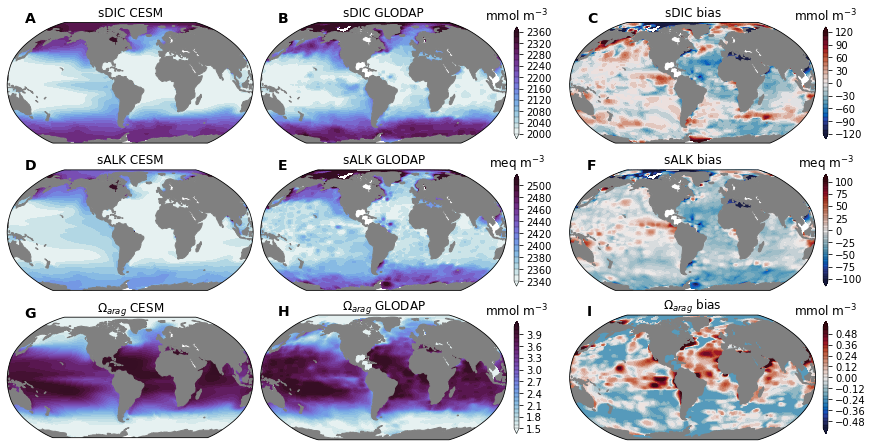

In [36]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 0.02, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

axs = []
maps = []
for i, field in enumerate(['sDIC', 'sALK', 'Omega_arag']):
    ax_m = plt.subplot(gs[i, 0], projection=prj)
    ax_o = plt.subplot(gs[i, 1], projection=prj)
    ax_b = plt.subplot(gs[i, 3], projection=prj)
    
    cax_field = plt.subplot(gs[i, 2])
    cax_bias = plt.subplot(gs[i, 4])
    
    axs.append((ax_m, ax_o, cax_field, ax_b, cax_bias))
    maps.extend([ax_m, ax_o, ax_b])
    
    cesm = ds_surf_plot[field]
    obs = ds_surf_obs_plot[field]
    bias = ds_surf_bias_plot[field]

    units = ds_surf_plot[field].units.replace('/m^3', ' m$^{-3}$')
        
    cf_m = ax_m.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
        **contour_spec[field],        
        transform=ccrs.PlateCarree(),
    )
    
    #cl_m = ax_m.contour(
    #    ds_surf_plot.TLONG, ds_surf_plot.TLAT, cesm, 
    #    levels=contour_spec[field]['levels'], colors='k', linewidths=0.2,
    #    transform=ccrs.PlateCarree(),        
    #)
    #contour_label(cl_m)   
    
    cf_o = ax_o.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
        **contour_spec[field],        
        transform=ccrs.PlateCarree(),        
    )
    
#     cl_o = ax_o.contour(
#         ds_surf_plot.TLONG, ds_surf_plot.TLAT, obs, 
#         levels=contour_spec[field]['levels'], colors='k', linewidths=0.2,
#         transform=ccrs.PlateCarree(),        
#     )
    #contour_label(cl_o)       
    
    cf_b = ax_b.contourf(
        ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
        **contour_spec[f'{field}_bias'],                     
        transform=ccrs.PlateCarree(),        
    )    

#     cl_b = ax_b.contour(
#         ds_surf_plot.TLONG, ds_surf_plot.TLAT, bias, 
#         levels=contour_spec[f'{field}_bias']['levels'], colors='k', linewidths=0.2,
#         transform=ccrs.PlateCarree(),        
#     )
    #contour_label(cl_b)       
    
    for ax in [ax_m, ax_o, ax_b]:
        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )        

    ax_m.set_title(f'{long_name[field]} CESM')
    ax_o.set_title(f'{long_name[field]} GLODAP')    
    ax_b.set_title(f'{long_name[field]} bias')        
    
    cb_field = plt.colorbar(cf_o, cax=cax_field, drawedges=True)
    cb_field.ax.set_title(units)
    cb_field.outline.set_linewidth(0.5)
    cb_field.dividers.set_linewidth(0.25)    
    
    cb_bias = plt.colorbar(cf_b, cax=cax_bias, drawedges=True)
    cb_bias.ax.set_title(units)
    cb_bias.outline.set_linewidth(0.5)
    cb_bias.dividers.set_linewidth(0.25)    
    
# add a gap between left two columns and right; scale colorbars
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
offset = 0.05
cax_vert_shrink = 0.8
for i in range(len(axs)):
    
    # the row of axis objects
    ax_m, ax_o, cax_field, ax_b, cax_bias = axs[i]
    
    # shift map
    p0 = ax_b.get_position()
    ax_b.set_position([p0.x0 + offset, p0.y0, p0.width, p0.height])

    # shift and scale colorbar
    p0 = cax_bias.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_bias.set_position([p0.x0 + offset, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

    # scale colorbar    
    p0 = cax_field.get_position()
    shift_up = p0.height * (1. - cax_vert_shrink) / 2
    cax_field.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

utils.label_plots(fig, maps, xoff=0.02, yoff=0)   

utils.savefig('dic-alk-omega-surface-maps')